# Train a FastText model with Slovene embeddings on the SLED categorization dataset

In [1]:
# Install and import fastText
!wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
!unzip v0.9.2.zip

%cd fastText-0.9.2

!pip install .
import fasttext as ft

--2022-09-01 05:52:35--  https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/v0.9.2 [following]
--2022-09-01 05:52:35--  https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/v0.9.2
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.9.2.zip’

v0.9.2.zip              [  <=>               ]   4.17M  12.3MB/s    in 0.3s    

2022-09-01 05:52:35 (12.3 MB/s) - ‘v0.9.2.zip’ saved [4369852]

Archive:  v0.9.2.zip
5b5943c118b0ec5fb9cd8d20587de2b2d3966dfe
   creating: fastText-0.9.2/
   creating: fastText-0.9.2/.circleci/
  i

In [2]:
%cd /content
%pwd

/content


'/content'

In [ ]:
# Install the parse module
!pip install parse

In [ ]:
!pip install wget

In [5]:
# Import necessary libraries
import parse
import fasttext as ft
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
import wget
import zipfile
import pandas as pd
from sklearn.metrics import classification_report

In [7]:
# Upload the data to google collab and define paths to them
# (click on the Folder on the right of the window, and click on the file icon ("Upload to session storage")
train = "/content/sled_categorization_TRAINLARGE_PREPROCESSED.txt"

test = "/content/sled_categorization_TEST_PREPROCESSED.txt"

dev = "/content/sled_categorization_DEV_PREPROCESSED.txt"

In [6]:
# Download and unzip a file with the Slovene embeddings
print('Downloading started')

#Defining the zip file URL
url = "https://www.clarin.si/repository/xmlui/bitstream/handle/11356/1204/embed.sl-token.ft.sg.vec.zip"

# Downloading the file by sending the request to the URL
embs = wget.download(url)
print('Downloading Completed')

# extracting the zip file contents
zipfile= zipfile.ZipFile(embs)
zipfile.extractall('data/')

In [8]:
# Parse the file to separate labels from text
def parse_file(path: str):
    """Reads fasttext formatted file and returns labels, texts."""
    with open(path, "r") as f:
        content = f.readlines()
    pattern = "{label} {text}\n"
    p = parse.compile(pattern)

    labels, texts = list(), list()
    for line in content:
        rez = p.parse(line)
        if rez is not None:
            labels.append(rez["label"])
            texts.append(rez["text"])
        else:
            print("error parsing line ", line)
    return labels, texts

In [9]:
# Create a list of texts and labels from the train file
train_labels, train_texts = parse_file(train)

# Inspect the results
train_texts[:3]

['vožnja na vrtiljaku v zabaviščnem parku v francoskem rennesu bi morala trajati le šest minut a se je na silvestrsko noč za osem francozov spremenila v pravo nočno moro zaradi tehnične okvare so namreč obtičali 52 metrov visoko in na rešitev čakali več kot osem ur  slišali smo glasen pok nato pa videli iskre ki so švigale okoli je povedal eden od nesrečnih francozov ki so obtičali na orkanskem vrtiljaku bombermaxxx ta je sestavljen iz 52 metrov dolge železne roke na obeh koncih pa so sedišča  trem odraslim in petim najstnikom starim med 13 in 17 je na pomoč priskočilo 20 gasilcev s petimi gasilskimi vozili a neuspešno saj je bila njihova 30-metrska lestev prekratka nato so poklicali helikopter a so potrebovali več ur da so pripravili vse potrebno za reševanje prvi potnik je bil na tleh ob 4 uri zadnji pa ob 6',
 'na tolminskem se je dopoldne zgodila prometna nesreča v kateri je umrl 43-letni voznik osebnega avtomobila po tem ko je zapeljal v 100 metrov globoko grapo  nesreča se je zgo

In [10]:
# Create a list of labels - by creating a set, we get only unique labels from the list of all labels,
# then we transform the set back to a list

LABELS = list(set(train_labels))

LABELS

['__label__okolje',
 '__label__gospodarstvo',
 '__label__izobrazevanje',
 '__label__crnakronika',
 '__label__prosticas',
 '__label__druzba',
 '__label__sport',
 '__label__zabava',
 '__label__politika',
 '__label__znanost',
 '__label__vreme',
 '__label__kultura',
 '__label__zdravje']

In [11]:
def prediction_to_label(prediction):
    """Transforms predictions as returned by fasttext into pure labels."""
    return np.array(prediction[0])[:, 0]

# Create a function to evaluate the results (it calculates the scores and creates a confusion matrix)
def plot_cm():
    """
    Plots confusion matrix for prediction on the test set.
    Takes the predictions, named as y_pred, true values, named as y_true,
    and labels, named as LABELS.
    """
    # Plot the confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()

    # Calculate micro and macro F1 scores
    microF1 = f1_score(y_true, y_pred, labels=LABELS, average ="micro")
    macroF1 = f1_score(y_true, y_pred, labels=LABELS, average ="macro")

    print(f"Micro F1: {microF1:0.4}, Macro F1: {macroF1:0.4}")

    return microF1, macroF1

## Hyperparameter search

In [12]:
# Create a list with results
results = []

Training started for epoch_num 1000.
Training finished. Testing started.
Training took 100.74 minutes.


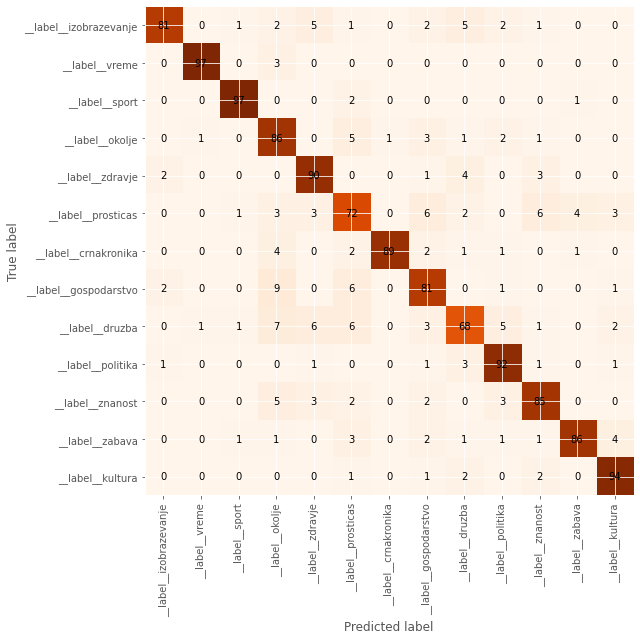

Micro F1: 0.86, Macro F1: 0.8603
Testing took 0.03 minutes.




<Figure size 432x288 with 0 Axes>

In [ ]:
# Define which epochs we want to try
#exp_range = [10, 50, 100, 200]
# Additional experiments
#exp_range = [300, 400, 500, 600]
#exp_range = [700]
#exp_range = [800, 900]
exp_range = [1000]

for i in exp_range:
    print(f"Training started for epoch_num {i}.")

    training_start_time = time.time()

    model = ft.train_supervised(input=train,
                                epoch = i,
                                verbose = 2,
                                pretrainedVectors = "data/embed.sl-token.ft.sg.vec"
                                            )

    print(f"Training finished. Testing started.")
    print(f"Training took {round((time.time() - training_start_time)/60,2)} minutes.")

    testing_start_time = time.time()
    # Parse the dev files so that labels and texts are separated
    y_true, y_texts = parse_file(dev)

    # Evaluate the model on dev data
    y_pred = model.predict(y_texts)
    y_pred = prediction_to_label(y_pred)

    # Plot the confusion matrix:
    m, M = plot_cm()
    
    rezdict = dict(
        microF1=m,
        macroF1=M,
        epoch_num = i,
    )
    results.append(rezdict)

    print(f"Testing took {round((time.time() - testing_start_time)/60,2)} minutes.\n\n")

Training on 1000 epochs achieved Micro F1: 0.86, Macro F1: 0.8603. The scores keep rising with the epoch number, but training on 1000 epochs already took 100 minutes, so I will for now stop searching for the epoch number and just use the 1000 epochs.

In [ ]:
results

[{'microF1': 0.5138461538461538,
  'macroF1': 0.46844091022218576,
  'epoch_num': 10},
 {'microF1': 0.7730769230769231,
  'macroF1': 0.7702444364083306,
  'epoch_num': 50},
 {'microF1': 0.7723076923076923,
  'macroF1': 0.768970781786052,
  'epoch_num': 100},
 {'microF1': 0.7984615384615384,
  'macroF1': 0.7982502164074738,
  'epoch_num': 200},
 {'microF1': 0.8215384615384616,
  'macroF1': 0.8234150985914077,
  'epoch_num': 300},
 {'microF1': 0.8353846153846154,
  'macroF1': 0.8370114388498686,
  'epoch_num': 400},
 {'microF1': 0.8476923076923077,
  'macroF1': 0.8485692242756513,
  'epoch_num': 500},
 {'microF1': 0.8484615384615385,
  'macroF1': 0.8494942452605598,
  'epoch_num': 600},
 {'microF1': 0.8530769230769231,
  'macroF1': 0.853908313028324,
  'epoch_num': 700},
 {'microF1': 0.8538461538461538,
  'macroF1': 0.854400294856542,
  'epoch_num': 800},
 {'microF1': 0.8561538461538462,
  'macroF1': 0.8563141512519177,
  'epoch_num': 900}]

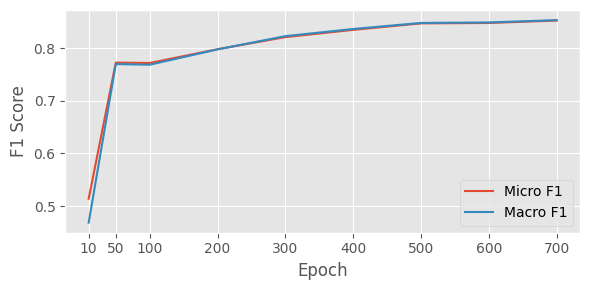

In [ ]:
# Analyse the results of experiments
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.style.use("ggplot")

# make data

x = []
mi = []
ma = []

for i in results:
    x.append(i['epoch_num'])
    mi.append(i['microF1'])
    ma.append(i["macroF1"])

# plot
plt.figure(figsize=(6,3), dpi=100)

plt.plot(x, mi, label="Micro F1")
plt.plot(x, ma, label="Macro F1")

plt.xticks(x)

plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc="lower right")

plt.tight_layout()

#plt.savefig(Epoch-number-hyperparameter-search.png")
plt.show()


In [ ]:
# Save results of the hyperparameter search as a JSON file
import json

with open("SLED-with-embeddings-hyperparameter-search-results.json","w") as file:
  json.dump(results, file)

## Training the model and testing it on the test set

Training started.
Training finished. Testing started.
Training took 86.06 minutes.


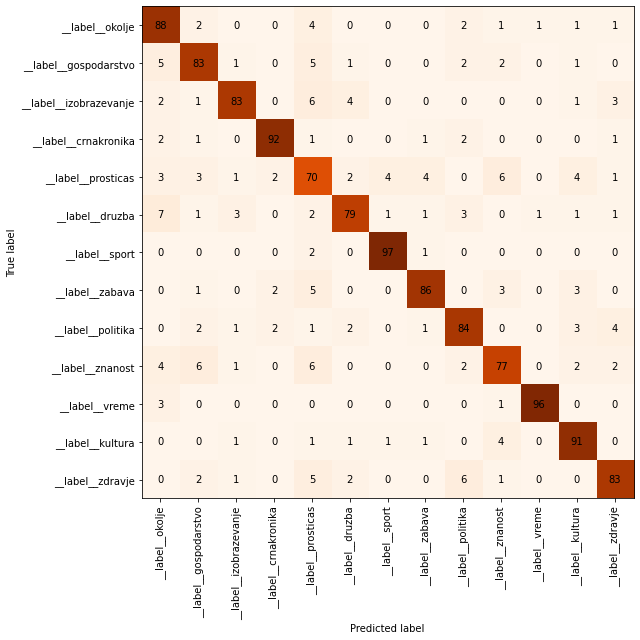

Micro F1: 0.8531, Macro F1: 0.8537
                        precision    recall  f1-score   support

       __label__okolje       0.77      0.88      0.82       100
 __label__gospodarstvo       0.81      0.83      0.82       100
__label__izobrazevanje       0.90      0.83      0.86       100
  __label__crnakronika       0.94      0.92      0.93       100
    __label__prosticas       0.65      0.70      0.67       100
       __label__druzba       0.87      0.79      0.83       100
        __label__sport       0.94      0.97      0.96       100
       __label__zabava       0.91      0.86      0.88       100
     __label__politika       0.83      0.84      0.84       100
      __label__znanost       0.81      0.77      0.79       100
        __label__vreme       0.98      0.96      0.97       100
      __label__kultura       0.85      0.91      0.88       100
      __label__zdravje       0.86      0.83      0.85       100

              accuracy                           0.85      1300
   

<Figure size 432x288 with 0 Axes>

In [13]:
test_results = []

for i in [1000]:
    print(f"Training started.")

    training_start_time = time.time()

    model = ft.train_supervised(input=train,
                                epoch = 1000,
                                verbose = 2,
                                pretrainedVectors = "data/embed.sl-token.ft.sg.vec")

    print(f"Training finished. Testing started.")
    print(f"Training took {round((time.time() - training_start_time)/60,2)} minutes.")

    testing_start_time = time.time()
    # Parse the test files so that labels and texts are separated
    y_true, y_texts = parse_file(test)

    # Test the model on test data
    y_pred = model.predict(y_texts)
    y_pred = prediction_to_label(y_pred)

    # Plot the confusion matrix:
    m, M = plot_cm()
    
    rezdict = dict(
        microF1=m,
        macroF1=M,
        epoch_num = i,
        y_true = {"y_true": y_true, "y_texts": y_texts},
        y_pred = y_pred,
    )
    test_results.append(rezdict)

        # Add classification report
    print(classification_report(y_true, y_pred, labels=LABELS))

    print(f"Testing took {round((time.time() - testing_start_time)/60,2)} minutes.\n\n")

In [14]:
# Inspect results in a dataframe format

df = pd.DataFrame(test_results)

df

,microF1,macroF1,epoch_num,y_true,y_pred
0,0.853077,0.853656,1000,"{'y_true': ['__label__crnakronika', '__label__...","[__label__crnakronika, __label__crnakronika, _..."


In [15]:
# Save results as csv file
df.to_csv("SLED-results-on-test-trainlarge-with-embeddings.csv", sep = "\t")

In [16]:
# Save the model
model.save_model("FastText-model-trainlarge-embeddings.bin")

In [17]:
# Save it to Wandb
!pip install wandb
import wandb

# Login to wandb
wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 11.6 MB/s 
     |████████████████████████████████| 122 kB 13.9 MB/s 
     |████████████████████████████████| 181 kB 47.1 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 157 kB 59.2 MB/s 
     |████████████████████████████████| 157 kB 50.9 MB/s 
     |████████████████████████████████| 157 kB 49.9 MB/s 
     |████████████████████████████████| 157 kB 51.2 MB/s 
     |████████████████████████████████| 157 kB 57.8 MB/s 
     |████████████████████████████████| 156 kB 70.2 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=74e1b13d5c14eba5424396865022be6c817e6af97ab0a79e8c22ce46a3884248
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [18]:
# Save the trained model to Wandb
run = wandb.init(project="SLED-categorization", name="saving-trainlarge-embeddings-model")
trained_model_artifact = wandb.Artifact("SLED-categorization-trainlarge-embeddings-model", type="model", description="a fastText model trained on the 'trainlarge' SLED dataset, trained with the pre-trained embeddings.")
trained_model_artifact.add_dir("/content/model")
run.log_artifact(trained_model_artifact)

wandb: Currently logged in as: tajak. Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (/content/model)... Done. 6.8s
